In [68]:
import pandas as pd
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from mlxtend.plotting import heatmap
from matplotlib import pyplot as plt


In [43]:
#Loading the data
columns = ['Overall Qual', 'Overall Cond','Gr Liv Area', 'Central Air','Total Bsmt SF','SalePrice']
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt', sep='\t', usecols=columns)
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [44]:
df.shape

(2930, 6)

In [45]:
# Converting 'Central Air' from categorical to numerical
df['Central Air'] = df['Central Air'].map({'Y':1, 'N':0})

In [46]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [47]:
#handling missing values by removing rows with missing values
df.dropna(axis=0)

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900
...,...,...,...,...,...,...
2925,6,6,1003.0,1,1003,142500
2926,5,5,864.0,1,902,131000
2927,5,5,912.0,1,970,132000
2928,5,5,1389.0,1,1389,170000


In [48]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

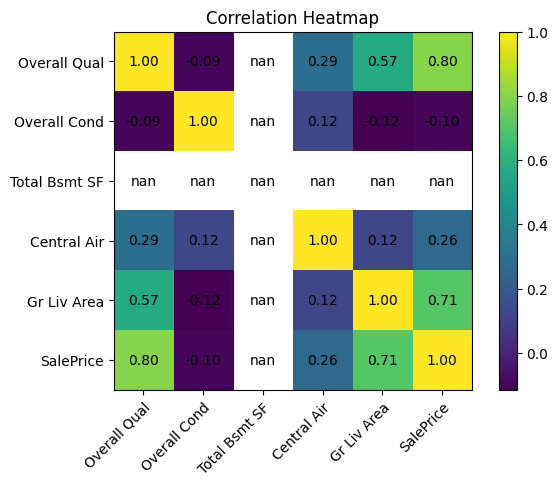

In [49]:
cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.title('Correlation Heatmap')
plt.show()


Linear Regression from scratch

In [50]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]   # w = w + eta * dL/dw   where   dL/dw = -2x(errors)/n 
            self.b_ += self.eta * 2.0 * errors.mean()               # b = b + eta * dL/db   where   dL/db = -2(errors)/n
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_   #z = w1x1 + w2x2 + ... + b
    
    def predict(self, X):
        return self.net_input(X)   

In [51]:
lr = LinearRegressionGD(eta=0.1)

In [52]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

plot of a linear regression model

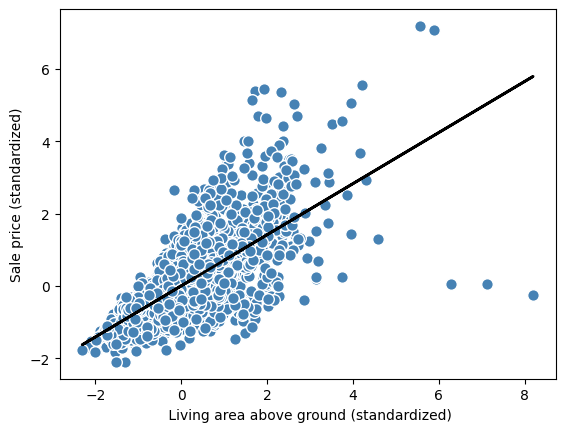

In [53]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

lin_regplot(X_std,y_std, lr)
plt.xlabel(' Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

Outliers can have a massive impact on linear regression models and cause them to be inaccurate sometimes. What is the solution to this problem? 


RANSAC (Random Sample Consensus) fits a regression model by repeatedly selecting random subsets of the data, estimating the model, and keeping the one with the most inliers, making it robust to outliers compared to ordinary least squares, which gets skewed by them.

In [54]:
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100, #default is 100
    min_samples=0.95, 
    residual_threshold=None, #default is None
    random_state=123
)

In [55]:
ransac.fit(X, y)

,estimator,LinearRegression()
,min_samples,0.95
,residual_threshold,None
,is_data_valid,None
,is_model_valid,None
,max_trials,100
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


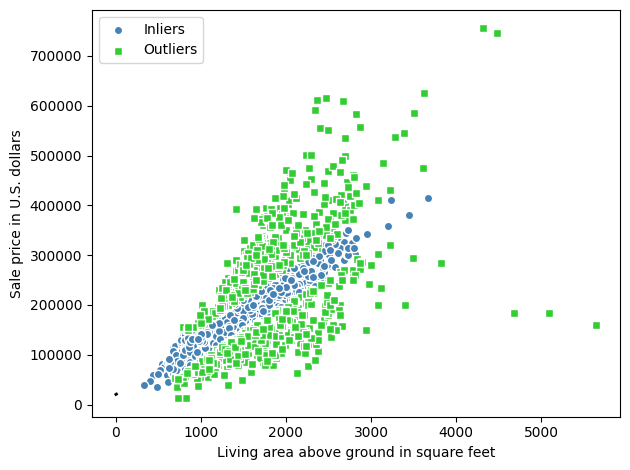

In [56]:
# Extracting the inlier and outlier mask
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predicting the values of the regression line
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

# plotting the regression line and the inliers and outliers
plt.scatter(
    X[inlier_mask], 
    y[inlier_mask], 
    c='steelblue', 
    edgecolor='white', 
    marker='o', 
    label='Inliers'
)
plt.scatter(X[outlier_mask], y[outlier_mask],
             c='limegreen', edgecolor='white',
             marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()

From RANSAC, 
Residual Threshold = None uses MAD(median absolute deviation)

What happens if the residual Threshold increases? 

In [57]:
#Calculating the MAD
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))
print(f"The residual threshold is {median_absolute_deviation(y)}")

The residual threshold is 37000.0


lets double the size of the residual threshold and see what happens

In [58]:
ransac2 = RANSACRegressor(
    LinearRegression(),
    max_trials=100, #default is 100
    min_samples=0.95, 
    residual_threshold=(37000 *2), #increasing the residual threshold to see result
    random_state=123
)

In [59]:
ransac2.fit(X, y)

,estimator,LinearRegression()
,min_samples,0.95
,residual_threshold,74000
,is_data_valid,None
,is_model_valid,None
,max_trials,100
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


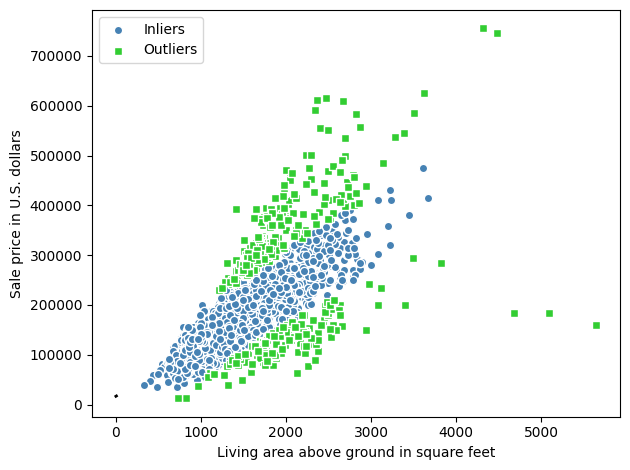

In [60]:
# Extracting the inlier and outlier mask
inlier_mask = ransac2.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predicting the values of the regression line
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac2.predict(line_X[:, np.newaxis])

# plotting the regression line and the inliers and outliers
plt.scatter(
    X[inlier_mask], 
    y[inlier_mask], 
    c='steelblue', 
    edgecolor='white', 
    marker='o', 
    label='Inliers'
)
plt.scatter(X[outlier_mask], y[outlier_mask],
             c='limegreen', edgecolor='white',
             marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()

#### Insights from comparison of RANSAC with Residual threshold of 3,700 VS 6,400
###### - We can see that when we increase the size of residual threshold, the inliers increase and the outliers decrease

#### Comparing Linear fit, second-degree (Quadratic) and third-degree(Cubic) polynomial fits

In [63]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values

In [ ]:
regr = LinearRegression()
# create quadratic and cubic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

In [70]:
# fit to features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

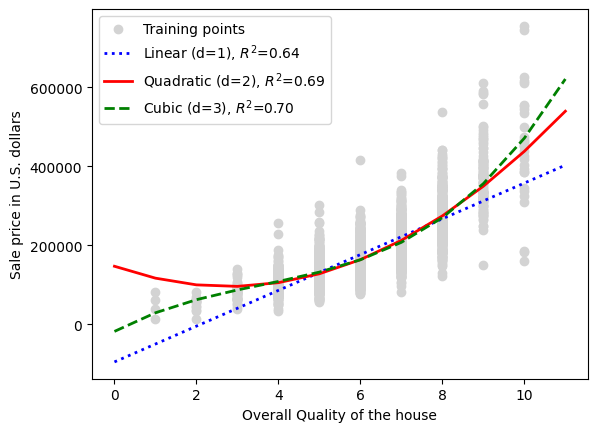

In [72]:
# plot results
plt.scatter(X, y, label='Training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, 
          label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
          color='blue', 
          lw=2, 
          linestyle=':')
plt.plot(X_fit, y_quad_fit, 
          label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
          color='red', 
          lw=2,
          linestyle='-')
plt.plot(X_fit, y_cubic_fit, 
          label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
          color='green', 
          lw=2,
          linestyle='--')
plt.xlabel('Overall Quality of the house')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.show()



Insights from comparing Linear, quadratic and cubic fit
- The quadratic and cubic fits capture the relationship between the sales prices and the Overall quality of the house better than the Linear fit